# Week 05 Group 40

## Import necessary modules

In [25]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Load the dataset

In [26]:
(input_train, label_train), (input_test, label_test) = tf.keras.datasets.cifar10.load_data()
print("min = {}max = {}".format(input_train.min(),input_train.max()))

min = 0max = 255


## Print some images with their lables

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


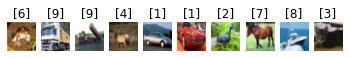

In [27]:
fig, ax = plt.subplots(1,10)
for i in range(10):

    # Readout an image and the corresponding label.
    img = input_train[i]
    lbl = label_train[i]

    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(lbl)
    ax[i].axis("off")

## Preprocess the data

In [29]:
length = len((input_train)/5)
def preprocess(input, label):
    input = input/255
    label = tf.one_hot(label, 10)
    label = tf.reshape(label, (-1,))
    return (input, label)
input_train = tf.data.Dataset.from_tensor_slices(input_train)
label_train = tf.data.Dataset.from_tensor_slices(label_train)
input_test = tf.data.Dataset.from_tensor_slices(input_test)
label_test = tf.data.Dataset.from_tensor_slices(label_test)
train_ds = tf.data.Dataset.zip((input_train, label_train)) 
test_ds = tf.data.Dataset.zip((input_test, label_test))
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
train_ds =   (tf.data.Dataset.shuffle(train_ds,buffer_size = 100000, reshuffle_each_iteration=True).batch(64)).prefetch(3)
test_ds =   (tf.data.Dataset.shuffle(test_ds,buffer_size = 100000, reshuffle_each_iteration=True).batch(64)).prefetch(3)

## Define the model

In [34]:
class Convmodel(tf.keras.Model):
    def __init__(self):
        # inherit information from the higher class
        super(Convmodel, self).__init__()
        
        self.target_height = 40
        self.target_width = 40
        # use convolutional layers with decreasing filter size and relu activation function
        self.hidden_layer1 = tf.keras.layers.Conv2D(filters = 90, kernel_size = (5,5), padding = "same", activation= "relu", input_shape = (self.target_height,self.target_width,3))
        # use pooling layers inbetween
        self.hidden_layer2 = tf.keras.layers.MaxPool2D()
        # dropout layer to prevent overfitting
        self.hidden_layer_dropout = tf.keras.layers.Dropout(rate = 0.3)
        self.hidden_layer3 = tf.keras.layers.Conv2D(filters = 80, kernel_size = 3, padding = "same", activation= "relu")
        self.hidden_layer4 = tf.keras.layers.MaxPool2D()
        self.hidden_layer5 = tf.keras.layers.Conv2D(filters = 70, kernel_size = 3, padding = "same", activation= "relu")
        self.hidden_layer13 = tf.keras.layers.Conv2D(filters = 60, kernel_size = 3, padding = "same", activation= "relu")
        self.hidden_layer6 = tf.keras.layers.MaxPool2D()
        self.hidden_layer7 = tf.keras.layers.Conv2D(filters = 50, kernel_size = 3, padding = "same", activation= "relu")
        self.hidden_layer8 = tf.keras.layers.Conv2D(filters = 40, kernel_size = 3, padding = "same", activation= "relu")
        self.hidden_layer9 = tf.keras.layers.MaxPool2D()
        self.hidden_layer10 = tf.keras.layers.Conv2D(filters = 20, kernel_size = 3, padding = "same", activation= "relu")
        self.hidden_layer11 = tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, padding = "same", activation= "relu")
        self.hidden_layer12 = tf.keras.layers.GlobalAveragePooling2D()
        # implement the output layer with 10 units and the softmax activation function
        self.output_layer = tf.keras.layers.Dense(units = 10, activation = tf.keras.activations.softmax)
    
    # define the forward step for the model
    def call(self, x, training_bool = False):
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.hidden_layer_dropout(x, training = training_bool)
        x = self.hidden_layer3(x)
        x = self.hidden_layer4(x)
        x = self.hidden_layer5(x)
        x = self.hidden_layer13(x)
        x = self.hidden_layer6(x)
        x = self.hidden_layer7(x)        
        x = self.hidden_layer8(x)
        x = self.hidden_layer9(x)
        x = self.hidden_layer10(x)
        x = self.hidden_layer11(x)
        x = self.hidden_layer12(x)
        x = self.output_layer(x)
        return x

## Define training and test step

In [31]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        expectation = model(input, training_bool = True)
        train_accuracy =  np.argmax(target, axis = 1) == np.argmax(expectation, axis = 1)
        loss = loss_function(target, expectation)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, train_accuracy

def test(model, test_data, loss_function):
    test_accuracies_total = []
    test_losses_total = []
    # Compute and return loss and accuracy of Test-data
    for (input, target) in test_data:
        expectation = model(input)
        test_loss = loss_function(target, expectation)
        test_accuracy =  np.argmax(target, axis = 1) == np.argmax(expectation, axis = 1)
        test_accuracy = np.mean(test_accuracy)
        test_accuracies_total.append(test_accuracy)
        test_losses_total.append(test_loss)
    
    # take the mean of all losses and all accuracies to get them for the whole test
    test_losses_total = np.mean(test_losses_total)
    test_accuracies_total = np.mean(test_accuracies_total)
    return test_losses_total, test_accuracies_total

## Train the Model for 30 epochs

In [35]:
num_epochs = 30
learning_rate = 0.001
# use categorical crossentropy as loss function
loss_function = tf.keras.losses.CategoricalCrossentropy()
# use adam as optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)
# initialize the model
model = Convmodel()

# lists for plotting later
test_loss_list = []
test_accuracy_list = []

train_loss_list = []
train_accuracy_list = []


# get loss on train data before training
train_loss, train_accuracy = test(model, train_ds, loss_function)
train_loss_list.append(train_loss)
train_accuracy_list.append(train_accuracy)

# test once before training
test_loss, test_accuracy = test(model, test_ds, loss_function)
test_loss_list.append(test_loss)
test_accuracy_list.append(test_accuracy)


# we train for the predefined number of epochs
for step in range(num_epochs):
    # reset average for each step
    changing_average = []
    train_accuracy_agg = []
    # train the model with the training data
    for (input, target) in train_ds:
        # perform training step and store the loss and accuracy of step
        train_loss, train_accuracy = train_step(model, input, target, loss_function, optimizer)
        changing_average.append(train_loss)
        train_accuracy_agg.append(np.mean(train_accuracy))

    # compute mean loss and accuracy of trainingcycle
    train_loss_list.append(np.mean(changing_average))
    train_accuracy_list.append(np.mean(train_accuracy_agg))
    
    # test on the test data
    test_loss, test_accuracy = test(model, test_ds, loss_function)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    print(step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


## Take a look at the accuracy and loss during training and on the test data

In [36]:
print(train_accuracy_list)
print(train_loss_list)
print(test_accuracy_list)
print(test_loss_list)

[0.10118286445012788, 0.2597906010230179, 0.45742087595907927, 0.5334878516624041, 0.5927709398976982, 0.6345308503836317, 0.6605458759590793, 0.6834438938618926, 0.7059622762148338, 0.7217071611253197, 0.7346147698209718, 0.7461037404092071, 0.760849584398977, 0.7701806265984654, 0.7801510549872123, 0.7846467391304348, 0.7956162084398977, 0.8003916240409207, 0.808963395140665, 0.8169757033248082, 0.8204923273657289, 0.8259670716112532, 0.8314018542199488, 0.8358975383631714, 0.8427309782608695, 0.843690057544757, 0.8488650895140665, 0.8550791240409207, 0.8560182225063938, 0.859434942455243, 0.8627117966751918]
[2.3027031, 1.9583457, 1.4705782, 1.2765423, 1.1352283, 1.0299813, 0.95649326, 0.8949265, 0.83593345, 0.7932994, 0.7559718, 0.7151973, 0.67930835, 0.65021116, 0.62499034, 0.60740215, 0.5794991, 0.5641313, 0.5396614, 0.51998055, 0.508134, 0.49357235, 0.47812197, 0.4638212, 0.44546422, 0.4391493, 0.4280839, 0.40993845, 0.4062448, 0.39806527, 0.38508785]
[0.10111464968152867, 0.407

## Plot the results

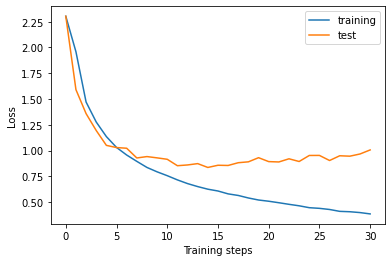

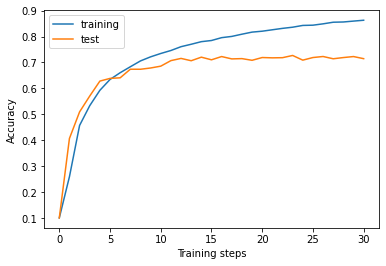

In [37]:
# Plot Figure displaying test and training loss for each epoch
plt.figure()
line1, = plt.plot(train_loss_list)
line2, = plt.plot(test_loss_list)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Plot Figure displaying test and training accuracy for each epoch
plt.figure()
line1, = plt.plot(train_accuracy_list)
line2, = plt.plot(test_accuracy_list)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1,line2),("training","test"))
plt.show()